In [12]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import cv2
from keras.models import load_model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import os

# Define paths and parameters
path = 'images'
imgDimension = (32, 32, 3)
testRatio = 0.2
valRatio = 0.2

# Initialize data arrays
images = []
classNo = []

def is_image_file(file):
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
    return any(file.lower().endswith(ext) for ext in valid_extensions)

# Load and preprocess the dataset
print("Importing Classes..........")
myList = os.listdir(path)
numOfClasses = len(myList)
for x in range(numOfClasses):
    myPicList = os.listdir(path + "/" + str(x))
    for y in myPicList:
        if not is_image_file(y):
            continue
        img_path = path + "/" + str(x) + "/" + y
        curImg = cv2.imread(img_path)
        if curImg is None:
            continue
        curImg = cv2.resize(curImg, (imgDimension[0], imgDimension[1]))
        images.append(curImg)
        classNo.append(x)
    print(f"Class {x} imported.")
    
images = np.array(images)
classNo = np.array(classNo)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valRatio)

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

# Convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes=numOfClasses)
y_test = to_categorical(y_test, num_classes=numOfClasses)
y_val = to_categorical(y_val, num_classes=numOfClasses)

# Define and compile the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),  # Input shape with 3 channels
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(numOfClasses, activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy*100:.2f}%')

# Save the model
model.save('my_model.keras')

# Function to preprocess and predict mask
def preprocessing(img):
    img = img.astype("uint8")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = (img / 255.0).astype(np.float32)  # Ensure it's in the correct float type
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert back to 3-channel
    return img

def get_className(classNo):
    if classNo == 0:
        return "Mask"
    elif classNo == 1:
        return "No Mask"

def predict_mask(img):
    img = cv2.resize(img, (32, 32))
    img = preprocessing(img)
    img = img.reshape(1, 32, 32, 3)  # Keep shape with 3 channels
    prediction = model.predict(img)
    classIndex = np.argmax(prediction, axis=1)[0]
    probabilityValue = np.amax(prediction)
    return classIndex, probabilityValue

# Real-time mask detection
facedetect = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
cap = cv2.VideoCapture(0)
cap.set(3, 640)
cap.set(4, 480)
font = cv2.FONT_HERSHEY_COMPLEX

while True:
    success, imgOrignal = cap.read()
    faces = facedetect.detectMultiScale(imgOrignal, 1.3, 5)
    for x, y, w, h in faces:
        crop_img = imgOrignal[y:y+h, x:x+w]
        classIndex, probabilityValue = predict_mask(crop_img)
        if probabilityValue > threshold:
            if classIndex == 0:
                cv2.rectangle(imgOrignal, (x, y), (x+w, y+h), (0, 255, 0), 2)
                cv2.rectangle(imgOrignal, (x, y-40), (x+w, y), (0, 255, 0), -2)
                cv2.putText(imgOrignal, str(get_className(classIndex)), (x, y-10), font, 0.75, (255, 255, 255), 1, cv2.LINE_AA)
            elif classIndex == 1:
                cv2.rectangle(imgOrignal, (x, y), (x+w, y+h), (50, 50, 255), 2)
                cv2.rectangle(imgOrignal, (x, y-40), (x+w, y), (50, 50, 255), -2)
                cv2.putText(imgOrignal, str(get_className(classIndex)), (x, y-10), font, 0.75, (255, 255, 255), 1, cv2.LINE_AA)
    cv2.imshow("Result", imgOrignal)
    k = cv2.waitKey(1)
    if k == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Importing Classes..........
Class 0 imported.
Class 1 imported.
Epoch 1/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5513 - loss: 0.6668 - val_accuracy: 1.0000 - val_loss: 0.4992
Epoch 2/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8181 - loss: 0.4778 - val_accuracy: 0.9792 - val_loss: 0.1268
Epoch 3/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8886 - loss: 0.3206 - val_accuracy: 1.0000 - val_loss: 0.0789
Epoch 4/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9464 - loss: 0.2032 - val_accuracy: 0.9896 - val_loss: 0.0589
Epoch 5/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9553 - loss: 0.1273 - val_accuracy: 0.9896 - val_loss: 0.0643
Epoch 6/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9754 - loss: 0.0793 - val_accuracy: 0.9896 - val_loss: 0.0502
Epoch 7/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9739 - loss: 0.0751 - val_accuracy: 0.9792 - val_loss: 0.0556
Epoch 8/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/s

In [4]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import cv2
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

# Define paths and parameters
path = 'images'
imgDimension = (32, 32, 3)
testRatio = 0.2
valRatio = 0.2

# Initialize data arrays
images = []
classNo = []

def is_image_file(file):
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
    return any(file.lower().endswith(ext) for ext in valid_extensions)

# Load and preprocess the dataset
print("Importing Classes..........")
myList = os.listdir(path)
numOfClasses = len(myList)
for x in range(numOfClasses):
    myPicList = os.listdir(path + "/" + str(x))
    for y in myPicList:
        if not is_image_file(y):
            continue
        img_path = path + "/" + str(x) + "/" + y
        curImg = cv2.imread(img_path)
        if curImg is None:
            continue
        curImg = cv2.resize(curImg, (imgDimension[0], imgDimension[1]))
        images.append(curImg)
        classNo.append(x)
    print(f"Class {x} imported.")
    
images = np.array(images)
classNo = np.array(classNo)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valRatio)

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

# Convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes=numOfClasses)
y_test = to_categorical(y_test, num_classes=numOfClasses)
y_val = to_categorical(y_val, num_classes=numOfClasses)

# Define and compile the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),  # Input shape with 3 channels
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(numOfClasses, activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy*100:.2f}%')

# Save the model
model.save('my_model.keras')


Importing Classes..........
Class 0 imported.
Class 1 imported.
Epoch 1/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5295 - loss: 0.6941 - val_accuracy: 0.6354 - val_loss: 0.6242
Epoch 2/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7212 - loss: 0.6182 - val_accuracy: 0.8646 - val_loss: 0.4411
Epoch 3/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9308 - loss: 0.3358 - val_accuracy: 0.9479 - val_loss: 0.1529
Epoch 4/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9395 - loss: 0.1683 - val_accuracy: 0.9479 - val_loss: 0.1208
Epoch 5/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9727 - loss: 0.1229 - val_accuracy: 0.9375 - val_loss: 0.2977
Epoch 6/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9181 - loss: 0.1837 - val_accuracy: 0.9583 - val_loss: 0.1408
Epoch 7/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9691 - loss: 0.0930 - val_accuracy: 0.9688 - val_loss: 0.1208
Epoch 8/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/s

In [6]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import cv2
from keras.models import load_model

# Function to preprocess and predict mask
def preprocessing(img):
    img = img.astype("uint8")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = (img / 255.0).astype(np.float32)  # Ensure it's in the correct float type
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert back to 3-channel
    return img

def get_className(classNo):
    if classNo == 0:
        return "Mask"
    elif classNo == 1:
        return "No Mask"

def predict_mask(img, model):
    img = cv2.resize(img, (32, 32))
    img = preprocessing(img)
    img = img.reshape(1, 32, 32, 3)  # Keep shape with 3 channels
    prediction = model.predict(img)
    classIndex = np.argmax(prediction, axis=1)[0]
    probabilityValue = np.amax(prediction)
    return classIndex, probabilityValue

# Load the model
model = load_model('my_model.keras')

# Real-time mask detection
facedetect = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
cap = cv2.VideoCapture(0)
cap.set(3, 640)
cap.set(4, 480)
font = cv2.FONT_HERSHEY_COMPLEX

while True:
    success, imgOrignal = cap.read()
    faces = facedetect.detectMultiScale(imgOrignal, 1.3, 5)
    for x, y, w, h in faces:
        crop_img = imgOrignal[y:y+h, x:x+w]
        classIndex, probabilityValue = predict_mask(crop_img, model)
        if probabilityValue > 0.9:  # Adjust threshold as needed
            if classIndex == 0:
                cv2.rectangle(imgOrignal, (x, y), (x+w, y+h), (0, 255, 0), 2)
                cv2.rectangle(imgOrignal, (x, y-40), (x+w, y), (0, 255, 0), -2)
                cv2.putText(imgOrignal, str(get_className(classIndex)), (x, y-10), font, 0.75, (255, 255, 255), 1, cv2.LINE_AA)
            elif classIndex == 1:
                cv2.rectangle(imgOrignal, (x, y), (x+w, y+h), (50, 50, 255), 2)
                cv2.rectangle(imgOrignal, (x, y-40), (x+w, y), (50, 50, 255), -2)
                cv2.putText(imgOrignal, str(get_className(classIndex)), (x, y-10), font, 0.75, (255, 255, 255), 1, cv2.LINE_AA)
    cv2.imshow("Result", imgOrignal)
    k = cv2.waitKey(1)
    if k == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

In [4]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import cv2
from keras.models import load_model
import threading

# Define the threshold for mask detection
threshold = 0.9  # Adjust this value as needed

# Function to preprocess and predict mask
def preprocessing(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = img.astype(np.float32) / 255.0
    return img

def get_className(classNo):
    return "Mask" if classNo == 0 else "No Mask"

def predict_mask(img, model):
    img = cv2.resize(img, (32, 32))
    img = preprocessing(img)
    img = img.reshape(1, 32, 32, 3)
    prediction = model.predict(img)
    classIndex = np.argmax(prediction, axis=1)[0]
    probabilityValue = np.amax(prediction)
    return classIndex, probabilityValue

# Function to detect masks in frames
def detect_masks(frame, model, facedetect, font):
    faces = facedetect.detectMultiScale(frame, 1.1, 4)  # Adjusted scale factor and neighbors for speed
    for x, y, w, h in faces:
        crop_img = frame[y:y+h, x:x+w]
        classIndex, probabilityValue = predict_mask(crop_img, model)
        if probabilityValue > threshold:  # Use the defined threshold
            color = (0, 255, 0) if classIndex == 0 else (50, 50, 255)
            cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
            cv2.rectangle(frame, (x, y-40), (x+w, y), color, -2)
            cv2.putText(frame, str(get_className(classIndex)), (x, y-10), font, 0.75, (255, 255, 255), 1, cv2.LINE_AA)
    return frame

# Load the model
model = load_model('my_model.keras')

# Real-time mask detection
facedetect = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
cap = cv2.VideoCapture(0)
cap.set(3, 320)  # Reduce frame width
cap.set(4, 240)  # Reduce frame height
font = cv2.FONT_HERSHEY_COMPLEX

while True:
    success, imgOrignal = cap.read()
    if not success:
        break

    # Create a thread for mask detection
    thread = threading.Thread(target=detect_masks, args=(imgOrignal, model, facedetect, font))
    thread.start()
    thread.join()

    cv2.imshow("Result", imgOrignal)
    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

Importing Classes..........
Class 0 imported.
Class 1 imported.


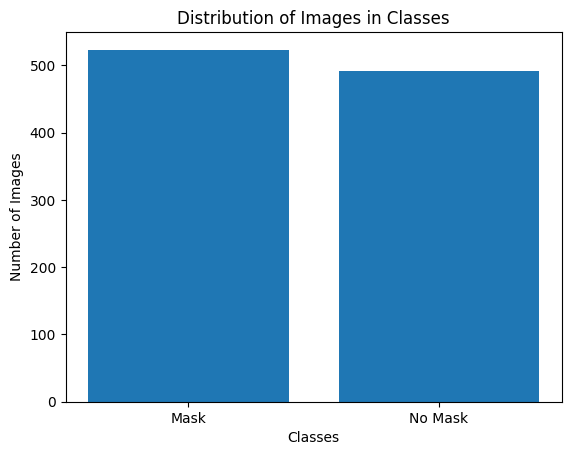

Epoch 1/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.5692 - loss: 0.6550 - val_accuracy: 0.6687 - val_loss: 0.5499
Epoch 2/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8870 - loss: 0.4007 - val_accuracy: 0.9509 - val_loss: 0.1975
Epoch 3/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9144 - loss: 0.2437 - val_accuracy: 0.9571 - val_loss: 0.1359
Epoch 4/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9648 - loss: 0.1074 - val_accuracy: 0.9632 - val_loss: 0.1123
Epoch 5/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9755 - loss: 0.0686 - val_accuracy: 0.9693 - val_loss: 0.1177
Epoch 6/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9834 - loss: 0.0759 - val_accuracy: 0.9571 - val_loss: 0.1121
Epoch 7/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9656 - loss: 0.1136 - val_accuracy: 0.9693 - val_loss: 0.0857
Epoch 8/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9874 - loss: 0.0531 - val_accuracy: 0.9693 - v

In [3]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Define paths and parameters
path = 'images'
imgDimension = (32, 32, 3)
testRatio = 0.2
valRatio = 0.2

# Initialize data arrays
images = []
classNo = []
class_counts = []  # To store counts of images in each class

def is_image_file(file):
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
    return any(file.lower().endswith(ext) for ext in valid_extensions)

# Load and preprocess the dataset
print("Importing Classes..........")
myList = os.listdir(path)
numOfClasses = len(myList)
for x in range(numOfClasses):
    myPicList = os.listdir(path + "/" + str(x))
    class_counts.append(len(myPicList))  # Count the number of images in each class
    for y in myPicList:
        if not is_image_file(y):
            continue
        img_path = path + "/" + str(x) + "/" + y
        curImg = cv2.imread(img_path)
        if curImg is None:
            continue
        curImg = cv2.resize(curImg, (imgDimension[0], imgDimension[1]))
        images.append(curImg)
        classNo.append(x)
    print(f"Class {x} imported.")
    
images = np.array(images)
classNo = np.array(classNo)

# Plot the distribution of images across classes
plt.bar(range(numOfClasses), class_counts, tick_label=['Mask', 'No Mask'])
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Classes')
plt.show()

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valRatio)

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

# Convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes=numOfClasses)
y_test = to_categorical(y_test, num_classes=numOfClasses)
y_val = to_categorical(y_val, num_classes=numOfClasses)

# Define and compile the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),  # Input shape with 3 channels
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(numOfClasses, activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy*100:.2f}%')

# Save the model
model.save('my_model.keras')


In [10]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import cv2
from keras.models import load_model

# Define the threshold for mask detection
threshold = 0.9

# Function to preprocess and predict mask
def preprocessing(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = img.astype(np.float32) / 255.0
    return img

def get_className(classNo):
    return "Mask" if classNo == 0 else "No Mask"

def predict_mask(img, model):
    img = cv2.resize(img, (32, 32))
    img = preprocessing(img)
    img = img.reshape(1, 32, 32, 3)
    prediction = model.predict(img)
    classIndex = np.argmax(prediction, axis=1)[0]
    probabilityValue = np.amax(prediction)
    return classIndex, probabilityValue

# Load the model
model = load_model('my_model.keras')

# Real-time mask detection
facedetect = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
cap = cv2.VideoCapture(0)
cap.set(3, 640)
cap.set(4, 480)
font = cv2.FONT_HERSHEY_COMPLEX

while True:
    success, imgOrignal = cap.read()
    if not success:
        break
    
    faces = facedetect.detectMultiScale(imgOrignal, 1.1, 4)
    for x, y, w, h in faces:
        crop_img = imgOrignal[y:y+h, x:x+w]
        classIndex, probabilityValue = predict_mask(crop_img, model)
        if probabilityValue > threshold:
            color = (0, 255, 0) if classIndex == 0 else (50, 50, 255)
            cv2.rectangle(imgOrignal, (x, y), (x+w, y+h), color, 2)
            cv2.rectangle(imgOrignal, (x, y-40), (x+w, y), color, -2)
            cv2.putText(imgOrignal, str(get_className(classIndex)), (x, y-10), font, 0.75, (255, 255, 255), 1, cv2.LINE_AA)

    cv2.imshow("Result", imgOrignal)
    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

Importing Classes..........
Class 0 imported.
Class 1 imported.


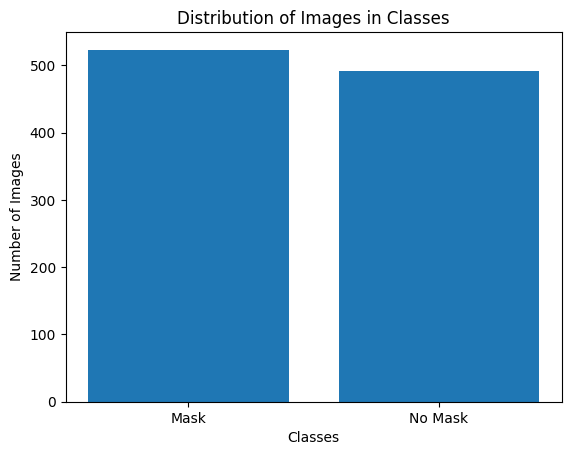

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5385 - loss: 0.6785 - val_accuracy: 0.9632 - val_loss: 0.4747
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8659 - loss: 0.3865 - val_accuracy: 0.9632 - val_loss: 0.1086
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9475 - loss: 0.1434 - val_accuracy: 0.9755 - val_loss: 0.1097
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9527 - loss: 0.1261 - val_accuracy: 0.9816 - val_loss: 0.0779
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9770 - loss: 0.0755 - val_accuracy: 0.9877 - val_loss: 0.0549
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9833 - loss: 0.0552 - val_accuracy: 0.9877 - val_loss: 0.0724
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9821 - loss: 0.0510 - val_accuracy: 0.9877 - val_loss: 0.0514
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9874 - loss: 0.0404 - val_accuracy: 0.9877 - v

In [11]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import cv2
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define paths and parameters
path = 'images'
imgDimension = (32, 32, 3)
testRatio = 0.2
valRatio = 0.2

# Initialize data arrays
images = []
classNo = []
class_counts = []

def is_image_file(file):
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
    return any(file.lower().endswith(ext) for ext in valid_extensions)

# Load and preprocess the dataset
print("Importing Classes..........")
myList = os.listdir(path)
numOfClasses = len(myList)
for x in range(numOfClasses):
    myPicList = os.listdir(path + "/" + str(x))
    class_counts.append(len(myPicList))
    for y in myPicList:
        if not is_image_file(y):
            continue
        img_path = path + "/" + str(x) + "/" + y
        curImg = cv2.imread(img_path)
        if curImg is None:
            continue
        curImg = cv2.resize(curImg, (imgDimension[0], imgDimension[1]))
        images.append(curImg)
        classNo.append(x)
    print(f"Class {x} imported.")
    
images = np.array(images)
classNo = np.array(classNo)

# Plot the distribution of images across classes
plt.bar(range(numOfClasses), class_counts, tick_label=['Mask', 'No Mask'])
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Classes')
plt.show()

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valRatio)

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

# Convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes=numOfClasses)
y_test = to_categorical(y_test, num_classes=numOfClasses)
y_val = to_categorical(y_val, num_classes=numOfClasses)

# Define and compile the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(numOfClasses, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with more epochs
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy*100:.2f}%')

# Save the model
model.save('my_model.keras')


In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import cv2
from keras.models import load_model

# Define the threshold for mask detection
threshold = 0.9

# Function to preprocess and predict mask
def preprocessing(img):
    if img is None:
        raise ValueError("Image not loaded correctly. Please check the file path.")
    img = cv2.resize(img, (32, 32))  # Resize to expected dimensions
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = img.astype(np.float32) / 255.0
    return img

def get_className(classNo):
    return "Mask" if classNo == 0 else "No Mask"

def predict_mask(img, model):
    img = preprocessing(img)
    img = img.reshape(1, 32, 32, 3)
    prediction = model.predict(img)
    classIndex = np.argmax(prediction, axis=1)[0]
    probabilityValue = np.amax(prediction)
    return classIndex, probabilityValue

# Load the model
model = load_model('my_model.keras')

# Real-time mask detection
facedetect = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
cap = cv2.VideoCapture(0)  # Open the default webcam
cap.set(3, 640)  # Set frame width
cap.set(4, 480)  # Set frame height
font = cv2.FONT_HERSHEY_COMPLEX

while True:
    success, imgOriginal = cap.read()
    if not success:
        break
    
    faces = facedetect.detectMultiScale(imgOriginal, 1.1, 4)
    for x, y, w, h in faces:
        crop_img = imgOriginal[y:y+h, x:x+w]
        classIndex, probabilityValue = predict_mask(crop_img, model)
        if probabilityValue > threshold:
            color = (0, 255, 0) if classIndex == 0 else (50, 50, 255)
            cv2.rectangle(imgOriginal, (x, y), (x+w, y+h), color, 2)
            cv2.rectangle(imgOriginal, (x, y-40), (x+w, y), color, -2)
            cv2.putText(imgOriginal, str(get_className(classIndex)), (x, y-10), font, 0.75, (255, 255, 255), 1, cv2.LINE_AA)

    cv2.imshow("Result", imgOriginal)
    if cv2.waitKey(1) == ord('q'):  # Press 'q' to quit
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━